In [58]:
import pandas as pd
import sys
from pathlib import Path
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Dynamically find the project root by looking for the 'src' folder
project_dir = Path.cwd()
while not (project_dir / "src").exists() and project_dir != project_dir.parent:
	project_dir = project_dir.parent
sys.path.append(str(project_dir / "src"))

# My custom functions and classes
from utils.paths import resolve_env_path, PROJECT_ROOT

Continentes                               11           10            00

Africa                                    Ok           Ok            Ok
America central e caribe                  Ok           Ok            No
America do norte                          Ok           Ok            No
America do Sul                            No           No            No
Ásia                                      No           Ok            No
Europa                                    Ok           Ok            Ok
Oceania                                   No           No            Ok
Total                                     No           Ok            No

In [59]:
# Load the SARIMA forecasts CSV file
file_path_00 = PROJECT_ROOT / "notebooks" / "modeling" / "00_sarima_forecasts_TEST.csv"
file_path_10 = PROJECT_ROOT / "notebooks" / "modeling" / "10_sarima_forecasts_TEST.csv"
file_path_11 = PROJECT_ROOT / "notebooks" / "modeling" / "11_sarima_forecasts_TEST.csv"

df_00 = pd.read_csv(file_path_00, parse_dates=["date"], index_col="date")
df_10 = pd.read_csv(file_path_10, parse_dates=["date"], index_col="date")
df_11 = pd.read_csv(file_path_11, parse_dates=["date"], index_col="date")

In [60]:
# Define the allowed continents for each model based on the markdown table
continents_00 = ["Africa", "Europa", "Oceania"]
continents_10 = ["Africa", "America_Central_E_Caribe", "America_Do_Norte", "Asia", "Europa", "TOTAL"]
continents_11 = ["Africa", "America_Central_E_Caribe", "Europa"]

# Note: I am mapping the Portuguese names from the markdown to the likely keys in the dataframe 
# (e.g., "America central e caribe" -> "America_Central_E_Caribe") based on the 'all_rmse' variable content seen in context.

# Filter the dataframes
df_00_filtered = df_00[df_00['continent'].isin(continents_00)].copy()
df_10_filtered = df_10[df_10['continent'].isin(continents_10)].copy()
df_11_filtered = df_11[df_11['continent'].isin(continents_11)].copy()

# Display unique continents in each filtered dataframe to verify
print("Continents in df_00_filtered:", df_00_filtered['continent'].unique())
print("Continents in df_10_filtered:", df_10_filtered['continent'].unique())
print("Continents in df_11_filtered:", df_11_filtered['continent'].unique())

Continents in df_00_filtered: ['Africa' 'Europa' 'Oceania']
Continents in df_10_filtered: ['Africa' 'America_Central_E_Caribe' 'America_Do_Norte' 'Asia' 'Europa'
 'TOTAL']
Continents in df_11_filtered: ['Africa' 'America_Central_E_Caribe' 'Europa']


In [61]:
df_00_filtered.head()

,continent,actual,forecast,error
date,,,,
2024-01-01,Africa,303.0,677.820801,-374.820801
2024-02-01,Africa,446.0,479.567034,-33.567034
2024-03-01,Africa,337.0,529.490515,-192.490515
2024-04-01,Africa,402.0,300.457453,101.542547
2024-05-01,Africa,397.0,299.706203,97.293797


In [62]:
def calculate_rmse_per_continent(df, model_name):
    # Calculate RMSE: sqrt(mean(error^2))
    rmse_series = df.groupby('continent')['error'].apply(lambda x: np.sqrt((x**2).mean()))
    return rmse_series.rename(model_name)

# Calculate RMSE for each filtered dataframe
rmse_00 = calculate_rmse_per_continent(df_00_filtered, 'RMSE_00')
rmse_10 = calculate_rmse_per_continent(df_10_filtered, 'RMSE_10')
rmse_11 = calculate_rmse_per_continent(df_11_filtered, 'RMSE_11')

# Combine into a single DataFrame
comparison_df = pd.concat([rmse_00, rmse_10, rmse_11], axis=1)

# Find the minimum RMSE and the corresponding model
comparison_df['Best_Model'] = comparison_df.idxmin(axis=1)

print(comparison_df)

                              RMSE_00       RMSE_10      RMSE_11 Best_Model
continent                                                                  
Africa                     184.401732    198.417672   207.875117    RMSE_00
Europa                    5579.955807   6327.902683  6929.082252    RMSE_00
Oceania                    383.388131           NaN          NaN    RMSE_00
America_Central_E_Caribe          NaN    486.812717   444.729722    RMSE_11
America_Do_Norte                  NaN   6062.527454          NaN    RMSE_10
Asia                              NaN    958.153670          NaN    RMSE_10
TOTAL                             NaN  30702.860368          NaN    RMSE_10


In [63]:
# Initialize a list to store the dataframes for the best models
best_model_data_list = []

# Iterate through each continent and its best model identified in comparison_df
for continent, row in comparison_df.iterrows():
    best_model_name = row['Best_Model']
    
    # Select the appropriate source dataframe based on the best model name
    if best_model_name == 'RMSE_00':
        source_df = df_00_filtered
    elif best_model_name == 'RMSE_10':
        source_df = df_10_filtered
    elif best_model_name == 'RMSE_11':
        source_df = df_11_filtered
    else:
        continue
        
    # Filter the source dataframe for the current continent
    # We use .copy() to avoid SettingWithCopy warnings when adding the 'model_used' column
    continent_data = source_df[source_df['continent'] == continent].copy()
    
    # Add a column to track which model was selected for this data
    continent_data['model_used'] = best_model_name
    
    # Append to the list
    best_model_data_list.append(continent_data)

# Concatenate all continent data into a single DataFrame
df_best_models = pd.concat(best_model_data_list)

# Sort by date (index) and continent for cleaner viewing
df_best_models = df_best_models.sort_values(by=['continent', 'date'])

print("Shape of best models dataframe:", df_best_models.shape)
print(df_best_models)

Shape of best models dataframe: (84, 5)
           continent    actual       forecast         error model_used
date                                                                  
2024-01-01    Africa     303.0     677.820801   -374.820801    RMSE_00
2024-02-01    Africa     446.0     479.567034    -33.567034    RMSE_00
2024-03-01    Africa     337.0     529.490515   -192.490515    RMSE_00
2024-04-01    Africa     402.0     300.457453    101.542547    RMSE_00
2024-05-01    Africa     397.0     299.706203     97.293797    RMSE_00
...              ...       ...            ...           ...        ...
2024-08-01     TOTAL   91504.0   93702.970354  -2198.970354    RMSE_10
2024-09-01     TOTAL  116003.0   85239.115903  30763.884097    RMSE_10
2024-10-01     TOTAL  130985.0   95838.386968  35146.613032    RMSE_10
2024-11-01     TOTAL  145148.0  100069.637218  45078.362782    RMSE_10
2024-12-01     TOTAL  176121.0  125739.016450  50381.983550    RMSE_10

[84 rows x 5 columns]


In [64]:
from utilsforecast.losses import rmse

In [65]:
sarima_11_df = df_11_filtered.loc[df_11_filtered["continent"].isin(["America_Central_E_Caribe", "America_Do_Sul", "America_Do_Norte"])]
sarima_00_df = df_00_filtered.loc[df_00_filtered["continent"].isin(["Africa", "Europa", "Oceania"])]
sarima_10_df = df_10_filtered.loc[df_10_filtered["continent"].isin(["America_Do_Norte", "Asia", "TOTAL"])]

sarima_df = pd.concat([sarima_00_df, sarima_10_df, sarima_11_df])

sarima_df=sarima_df.rename(columns={"forecast": "sarima_forecast"})

rmse_sarima = rmse(sarima_df, models=["sarima_forecast"], target_col="actual", id_col="continent")
rmse_sarima

,continent,sarima_forecast
0,Africa,184.401732
1,America_Central_E_Caribe,444.729722
2,America_Do_Norte,6062.527454
3,Asia,958.153670
4,Europa,5579.955807
5,Oceania,383.388131
6,TOTAL,30702.860368


In [66]:
continents_00 = ["Africa", "Europa", "Oceania"]
continents_10 = ["America_Do_Norte", "Asia", "TOTAL"]
continents_11 = ["America_Central_E_Caribe", "America_Do_Sul", "America_Do_Norte"]

sarima_11_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "11_sarima_forecasts_TEST.csv")
sarima_11_df = sarima_11_df.loc[sarima_11_df["continent"].isin(["America_Central_E_Caribe", "America_Do_Sul", "America_Do_Norte"])]
sarima_10_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "10_sarima_forecasts_TEST.csv")
sarima_10_df = sarima_10_df.loc[sarima_10_df["continent"].isin(["America_Do_Norte", "Asia", "TOTAL"])]
sarima_00_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "00_sarima_forecasts_TEST.csv")
sarima_00_df = sarima_00_df.loc[sarima_00_df["continent"].isin(["Africa", "Europa", "Oceania"])]

# TESTE
# Previsoes do sarima
# sarima_df = pd.read_csv("00_sarima_forecasts.csv")
sarima_df = pd.concat([sarima_11_df, sarima_10_df, sarima_00_df])


# Renomeando colunas
sarima_df=sarima_df.rename(columns={"forecast": "sarima_forecast"})

# TREINO
# Previsoes do sarima
sarima_11_train_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "11_sarima_forecasts_TRAIN.csv")
sarima_11_train_df = sarima_11_train_df.loc[sarima_11_train_df["continent"].isin(["America_Central_E_Caribe", "America_Do_Sul", "America_Do_Norte"])]

sarima_10_train_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "10_sarima_forecasts_TRAIN.csv")
sarima_10_train_df = sarima_10_train_df.loc[sarima_10_train_df["continent"].isin(["America_Do_Norte", "Asia", "TOTAL"])]

sarima_00_train_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "00_sarima_forecasts_TRAIN.csv")
sarima_00_train_df = sarima_00_train_df.loc[sarima_00_train_df["continent"].isin(["Africa", "Europa", "Oceania"])]


# Concatenando oceania e geral
sarima_train_full_df = pd.concat([sarima_11_train_df, sarima_10_train_df, sarima_00_train_df])

# Renomeando colunas
sarima_train_full_df=sarima_train_full_df.rename(columns={"forecast": "sarima_forecast"})

# Gerando rmse do sarima
rmse_sarima = rmse(sarima_df, models=["sarima_forecast"], target_col="actual", id_col="continent")

rmse_sarima

,continent,sarima_forecast
0,Africa,184.401732
1,America_Central_E_Caribe,444.729722
2,America_Do_Norte,5879.822735
3,America_Do_Sul,20126.560588
4,Asia,958.153670
5,Europa,5579.955807
6,Oceania,383.388131
7,TOTAL,30702.860368


In [67]:
# america do norte
ets_na_test = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "forecast_ets_america_do_norte.csv")
ets_na_test["continent"] = "America_Do_Norte"
ets_na_test = ets_na_test.rename(columns={"forecast":"ets_forecast"})
ets_na_test

# oceania
ets_oc_test = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "forecast_ets_oceania.csv")
ets_oc_test["continent"] = "Oceania"
ets_oc_test = ets_oc_test.rename(columns={"forecast":"ets_forecast"})
ets_oc_test

# africa
ets_af_test = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "forecast_ets_africa.csv")
ets_af_test["continent"] = "Africa"
ets_af_test = ets_af_test.rename(columns={"forecast":"ets_forecast"})
ets_af_test

# america do norte
ets_ac_test = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "forecast_models_america_central_e_caribe.csv")
ets_ac_test["continent"] = "America_Central_E_Caribe"
ets_ac_test = ets_ac_test.rename(columns={"forecast":"ets_forecast"})
ets_ac_test

# america do norte
ets_as_test = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "forecast_models_america_do_sul.csv")
ets_as_test["continent"] = "America_Do_Sul"
ets_as_test = ets_as_test.rename(columns={"forecast":"ets_forecast"})
ets_as_test

# asia
ets_a_test = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "forecast_models_asia.csv")
ets_a_test["continent"] = "Asia"
ets_a_test = ets_a_test.rename(columns={"forecast":"ets_forecast"})
ets_a_test

# europa
ets_eu_test = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "forecast_models_europa.csv")
ets_eu_test["continent"] = "Europa"
ets_eu_test = ets_eu_test.rename(columns={"forecast":"ets_forecast"})
ets_eu_test

# total
ets_total_test = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "forecasts_comparison.csv")
ets_total_test["continent"] = "TOTAL"
ets_total_test = ets_total_test.rename(columns={"forecast":"ets_forecast"})
ets_total_test


# Full dataset
ets_df = pd.concat([ets_na_test, ets_oc_test, ets_a_test, ets_ac_test, ets_as_test, ets_af_test, ets_eu_test, ets_total_test])

ets_train_df = ets_df.loc[ets_df["date"] <= "2023-12-01",:]
ets_test_df = ets_df.loc[ets_df["date"] > "2023-12-01",:]

# Rmse
rmse_ets = rmse(ets_test_df, models=["ets_forecast"], target_col="actual", id_col="continent")
rmse_ets

,continent,ets_forecast
0,Africa,124.573622
1,America_Central_E_Caribe,450.534789
2,America_Do_Norte,6161.036595
3,America_Do_Sul,17860.450726
4,Asia,1248.915710
5,Europa,5508.584443
6,Oceania,469.265911
7,TOTAL,35079.436221


In [68]:
sarima_ets_df = rmse_ets.merge(rmse_sarima, on="continent")

# Add America_Do_Sul manually since it's missing from SARIMA results (likely no SARIMA model was selected for it)
# We get the ETS RMSE for America_Do_Sul
rmse_ets_as = rmse_ets.loc[rmse_ets["continent"] == "America_Do_Sul", "ets_forecast"].values[0]

# Create a new row
new_row = pd.DataFrame({
    "continent": ["America_Do_Sul"],
    "ets_forecast": [rmse_ets_as],
    "sarima_forecast": [np.nan] # No SARIMA forecast available
})

# Concatenate with the existing dataframe
sarima_ets_df = pd.concat([sarima_ets_df, new_row], ignore_index=True)
sarima_ets_df

,continent,ets_forecast,sarima_forecast
0,Africa,124.573622,184.401732
1,America_Central_E_Caribe,450.534789,444.729722
2,America_Do_Norte,6161.036595,5879.822735
3,America_Do_Sul,17860.450726,20126.560588
4,Asia,1248.915710,958.153670
5,Europa,5508.584443,5579.955807
6,Oceania,469.265911,383.388131
7,TOTAL,35079.436221,30702.860368
8,America_Do_Sul,17860.450726,NaN


XGBOOST passa em todos - ásia

In [69]:
# Importando dataset e renomeando coluna da previsao
xgboost_df_cat22 = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "xgboost_forecasts_catch.csv")
xgboost_df_cat22 = xgboost_df_cat22.rename(columns={"forecast": "xgboost_forecast"})
xgboost_df_cat22.loc[xgboost_df_cat22["continent"] == "TOTAL (Agregado)", "continent"] = "TOTAL"

# Xgboost train
xgboost_train_df_cat22 = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "xgboost_forecasts_TRAIN_catch.csv")
xgboost_train_df_cat22 = xgboost_train_df_cat22.loc[xgboost_train_df_cat22["continent"] != "Ásia"]
xgboost_train_df_cat22 = xgboost_train_df_cat22.rename(columns={"forecast": "xgboost_forecast"})
xgboost_train_df_cat22.loc[xgboost_train_df_cat22["continent"] == "TOTAL (Agregado)", "continent"] = "TOTAL"
# Gerando tabela do rmse
rmse_xgboost_cat22 = rmse(xgboost_df_cat22, models=["xgboost_forecast"], target_col="actual", id_col="continent")
rmse_xgboost_cat22.loc[rmse_xgboost_cat22["continent"] == "TOTAL (Agregado)", "continent"] = "TOTAL"
rmse_xgboost_cat22

,continent,xgboost_forecast
0,Africa,162.924297
1,America_Central_E_Caribe,298.916801
2,America_Do_Norte,4153.715261
3,America_Do_Sul,17174.122302
4,Asia,889.245136
5,Europa,3980.165875
6,Oceania,221.658055
7,TOTAL,27706.262691


In [70]:
sarima_ets_XGcat22_df = sarima_ets_df.merge(rmse_xgboost_cat22, on="continent")
sarima_ets_XGcat22_df


,continent,ets_forecast,sarima_forecast,xgboost_forecast
0,Africa,124.573622,184.401732,162.924297
1,America_Central_E_Caribe,450.534789,444.729722,298.916801
2,America_Do_Norte,6161.036595,5879.822735,4153.715261
3,America_Do_Sul,17860.450726,20126.560588,17174.122302
4,Asia,1248.915710,958.153670,889.245136
5,Europa,5508.584443,5579.955807,3980.165875
6,Oceania,469.265911,383.388131,221.658055
7,TOTAL,35079.436221,30702.860368,27706.262691
8,America_Do_Sul,17860.450726,NaN,17174.122302


In [71]:
# Importando dataset e renomeando coluna da previsao
xgboost_df_cat22_exog = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "xgboost_forecasts_catch_exog.csv")
xgboost_df_cat22_exog = xgboost_df_cat22_exog.rename(columns={"forecast": "xgboost_forecast_exog"})
xgboost_df_cat22_exog.loc[xgboost_df_cat22_exog["continent"] == "TOTAL (Agregado)", "continent"] = "TOTAL"

# Xgboost train
xgboost_train_df_cat22_exog = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "xgboost_forecasts_TRAIN_catch_exog.csv")
xgboost_train_df_cat22_exog = xgboost_train_df_cat22_exog.loc[xgboost_train_df_cat22_exog["continent"] != "Ásia"]

xgboost_train_df_cat22_exog = xgboost_train_df_cat22_exog.rename(columns={"forecast": "xgboost_forecast_exog"})
xgboost_train_df_cat22_exog.loc[xgboost_train_df_cat22_exog["continent"] == "TOTAL (Agregado)", "continent"] = "TOTAL"
# Gerando tabela do rmse
rmse_xgboost_cat22_exog = rmse(xgboost_df_cat22_exog, models=["xgboost_forecast_exog"], target_col="actual", id_col="continent")
rmse_xgboost_cat22_exog.loc[rmse_xgboost_cat22_exog["continent"] == "TOTAL (Agregado)", "continent"] = "TOTAL"
rmse_xgboost_cat22_exog

,continent,xgboost_forecast_exog
0,Africa,86.844076
1,America_Central_E_Caribe,364.471712
2,America_Do_Norte,3541.135324
3,America_Do_Sul,15089.173879
4,Asia,952.934632
5,Europa,4056.911703
6,Oceania,217.098344
7,TOTAL,21705.415325


In [72]:
sarima_ets_XGcat22_XGcat22exog_df = sarima_ets_XGcat22_df.merge(rmse_xgboost_cat22_exog, on="continent")
sarima_ets_XGcat22_XGcat22exog_df


,continent,ets_forecast,sarima_forecast,xgboost_forecast,xgboost_forecast_exog
0,Africa,124.573622,184.401732,162.924297,86.844076
1,America_Central_E_Caribe,450.534789,444.729722,298.916801,364.471712
2,America_Do_Norte,6161.036595,5879.822735,4153.715261,3541.135324
3,America_Do_Sul,17860.450726,20126.560588,17174.122302,15089.173879
4,Asia,1248.915710,958.153670,889.245136,952.934632
5,Europa,5508.584443,5579.955807,3980.165875,4056.911703
6,Oceania,469.265911,383.388131,221.658055,217.098344
7,TOTAL,35079.436221,30702.860368,27706.262691,21705.415325
8,America_Do_Sul,17860.450726,NaN,17174.122302,15089.173879


In [73]:

# 11_sarimax_forecasts (filtra total, america_central_caribe, america_norte, asia)
# 01_sarimax_forecasts (filtra america_do_sul, europa)
# 00_sarimax_forecasts (filtra africa)

sarimax_11_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "11_sarimax_forecasts.csv")
sarimax_11_df = sarimax_11_df.loc[sarimax_11_df["continent"].isin(["America_Central_E_Caribe", "America_Do_Norte", "Asia", "TOTAL"])]

sarimax_01_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "01_sarimax_forecasts.csv")
sarimax_01_df = sarimax_01_df.loc[sarimax_01_df["continent"].isin(["America_Do_Sul", "Europa"])]

sarimax_00_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "00_sarimax_forecasts.csv")
sarimax_00_df = sarimax_00_df.loc[sarimax_00_df["continent"].isin(["Africa"])]

# TESTE
# Previsoes do sarimax
# sarimax_df = pd.read_csv("00_sarimax_forecasts.csv")
sarimax_df = pd.concat([sarimax_11_df, sarimax_01_df, sarimax_00_df])
sarimax_df = sarimax_df.loc[sarimax_df["continent"] != "Oceania"]


# Previsoes do sarimax oceania
oceania_sarimax_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "oceania_sarimax_forecasts.csv")

# Concatenando oceania e geral
sarimax_df = pd.concat([sarimax_df, oceania_sarimax_df])

# Renomeando colunas
sarimax_df=sarimax_df.rename(columns={"forecast": "sarimax_forecast"})

# TREINO
# Previsoes do sarimax
sarimax_11_train_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "11_sarimax_forecasts_TRAIN.csv")
sarimax_11_train_df = sarimax_11_train_df.loc[sarimax_11_train_df["continent"].isin(["America_Central_E_Caribe", "America_Do_Norte", "Asia", "TOTAL"])]

sarimax_01_train_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "01_sarimax_forecasts_TRAIN.csv")
sarimax_01_train_df = sarimax_01_train_df.loc[sarimax_01_train_df["continent"].isin(["America_Do_Sul", "Europa"])]

sarimax_00_train_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "00_sarimax_forecasts_TRAIN.csv")
sarimax_00_train_df = sarimax_00_train_df.loc[sarimax_00_train_df["continent"].isin(["Africa"])]

# Previsoes do sarimax oceania
oceania_sarimax_train_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "oceania_sarimax_forecasts_TRAIN.csv")

# Concatenando oceania e geral
sarimax_train_full_df = pd.concat([sarimax_11_train_df, sarimax_01_train_df, sarimax_00_train_df,oceania_sarimax_train_df])

# Renomeando colunas
sarimax_train_full_df=sarimax_train_full_df.rename(columns={"forecast": "sarimax_forecast"})

# Gerando rmse do sarimax
rmse_sarimax = rmse(sarimax_df, models=["sarimax_forecast"], target_col="actual", id_col="continent")

rmse_sarimax

,continent,sarimax_forecast
0,Africa,118.878661
1,America_Central_E_Caribe,364.743257
2,America_Do_Norte,3501.264820
3,America_Do_Sul,21062.833030
4,Asia,957.008580
5,Europa,5885.345992
6,Oceania,393.809531
7,TOTAL,25508.990460


In [74]:
sarima_sarimax_ets_XGcat22_XGcat22exog_df = sarima_ets_XGcat22_XGcat22exog_df.merge(rmse_sarimax, on="continent")
sarima_sarimax_ets_XGcat22_XGcat22exog_df

,continent,ets_forecast,sarima_forecast,xgboost_forecast,xgboost_forecast_exog,sarimax_forecast
0,Africa,124.573622,184.401732,162.924297,86.844076,118.878661
1,America_Central_E_Caribe,450.534789,444.729722,298.916801,364.471712,364.743257
2,America_Do_Norte,6161.036595,5879.822735,4153.715261,3541.135324,3501.264820
3,America_Do_Sul,17860.450726,20126.560588,17174.122302,15089.173879,21062.833030
4,Asia,1248.915710,958.153670,889.245136,952.934632,957.008580
5,Europa,5508.584443,5579.955807,3980.165875,4056.911703,5885.345992
6,Oceania,469.265911,383.388131,221.658055,217.098344,393.809531
7,TOTAL,35079.436221,30702.860368,27706.262691,21705.415325,25508.990460
8,America_Do_Sul,17860.450726,NaN,17174.122302,15089.173879,21062.833030


In [75]:
def create_hts3_df(xgb_df, xgb_exog_df, sar_df):

    # Xgboost dataset
    xgb_df = xgb_df.copy()
    xgb_df = xgb_df.loc[xgb_df["continent"].isin(["America_Central_E_Caribe", "Europa"])]
    xgb_df = xgb_df.loc[:, ["date", "continent", "actual", "xgboost_forecast"]]
    xgb_df = xgb_df.rename(columns={"xgboost_forecast":"forecast", "TOTAL (Agregado)": "TOTAL"})
    # xgb_df = xgb_df.loc[xgb_df["continent"] !=    "]

    xgb_exog_df = xgb_exog_df.copy()
    xgb_exog_df = xgb_exog_df.loc[xgb_exog_df["continent"].isin(["America_Do_Norte", "Oceania", "TOTAL", "America_Do_Sul"])]
    xgb_exog_df = xgb_exog_df.loc[:, ["date", "continent", "actual", "xgboost_forecast_exog"]]
    xgb_exog_df = xgb_exog_df.rename(columns={"xgboost_forecast_exog":"forecast", "TOTAL (Agregado)": "TOTAL"})
    # xgb_exog_df = xgb_exog_df.loc[xgb_exog_df["continent"] !=    "]

    # sarima
    sar_df = sar_df.copy()
    sar_df = sar_df.loc[sar_df["continent"].isin(["Asia"])]
    sar_df = sar_df.loc[:, ["date", "continent", "actual", "sarima_forecast"]]
    sar_df = sar_df.rename(columns={"sarima_forecast":"forecast"})
    # sar_df = sar_df.loc[sar_df["continent"] != "TOTAL"]

    # Concat
    df = pd.concat([xgb_df, xgb_exog_df, sar_df])

    return df

In [76]:
def create_hts4_df(sar_df, ets_df):

    # ets dataset
    ets_df = ets_df.copy()
    ets_df = ets_df.loc[ets_df["continent"].isin(["America_Do_Sul", "Europa", "Africa"])]
    ets_df = ets_df.loc[:, ["date", "continent", "actual", "ets_forecast"]]
    ets_df = ets_df.rename(columns={"ets_forecast":"forecast"})
    #ets_df = ets_df.loc[ets_df["continent"] != "TOTAL"]

    # sarima
    sar_df = sar_df.copy()
    sar_df = sar_df.loc[sar_df["continent"].isin(["Oceania", "America_Central_E_Caribe", "America_Do_Norte", "Asia", "TOTAL"])]
    sar_df = sar_df.loc[:, ["date", "continent", "actual", "sarima_forecast"]]
    sar_df = sar_df.rename(columns={"sarima_forecast":"forecast"})
    # sar_df = sar_df.loc[sar_df["continent"] != "TOTAL"]

    # Concat
    df = pd.concat([sar_df, ets_df])

    return df

In [77]:
# HTS 3
hts3_train_df = create_hts3_df(xgboost_train_df_cat22, xgboost_train_df_cat22_exog, sarima_train_full_df)
hts3_test_df = create_hts3_df(xgboost_df_cat22, xgboost_df_cat22_exog, sarima_df)
hts3_test_df.to_csv(PROJECT_ROOT / "notebooks" / "modeling" / "hts3_test_df.csv", index=False)
hts3_train_df.to_csv(PROJECT_ROOT / "notebooks" / "modeling" / "hts3_train_df.csv", index=False)

# HTS 4:
hts4_train_df = create_hts4_df(sarima_train_full_df, ets_train_df)
hts4_test_df = create_hts4_df(sarima_df, ets_test_df)
hts4_train_df.to_csv(PROJECT_ROOT / "notebooks" / "modeling" / "hts4_train_df.csv", index=False)
hts4_test_df.to_csv(PROJECT_ROOT / "notebooks" / "modeling" / "hts4_test_df.csv", index=False)

Aqui começa o HTS!

In [78]:
from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import MinTrace
from hierarchicalforecast.evaluation import evaluate

def prepare_bottom_level(df: pd.DataFrame) -> pd.DataFrame:
    # Mantém apenas continentes (bottom level)
    df = df[df["continent"] != "TOTAL"].copy()

    df["World"] = "TOTAL"  # nível mais agregado

    df = df.rename(
        columns={
            "date": "ds",
            "continent": "Continent",
            "actual": "y",          # alvo
            "forecast": "BaseModel" # previsões base do seu modelo
        }
    )
    return df[["World", "Continent", "ds", "y", "BaseModel"]]

In [79]:
# ---------------------------------------------------------
# 1. Carregar dados de treino e teste
#    (antes de 2024 = treino, 2024 = teste)
# ---------------------------------------------------------

train = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "hts3_train_df.csv")
test  = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "hts3_test_df.csv")

# Converte data
for df in (train, test):
    df["date"] = pd.to_datetime(df["date"])



bottom_train = prepare_bottom_level(train)
bottom_test  = prepare_bottom_level(test)

# ---------------------------------------------------------
# 3. Construir a hierarquia (Total -> Continente) com aggregate
#    spec define os níveis:
#    - ["World"]                        -> série TOTAL
#    - ["World", "Continent"]          -> séries por continente
# ---------------------------------------------------------
hierarchy_levels = [
    ["World"],
    ["World", "Continent"]
]

# Treino: contém y (actual) + BaseModel (previsão 1-step-ahead/insample)
Y_train_df_3, S_df_3, tags = aggregate(
    df=bottom_train,
    spec=hierarchy_levels,
    target_cols=["y", "BaseModel"]  # agrega ambos
)

# Teste: contém y (valor observado no teste) + BaseModel (previsão out-of-sample)
Y_test_df_3, _, _ = aggregate(
    df=bottom_test,
    spec=hierarchy_levels,
    target_cols=["y", "BaseModel"]
)

# ---------------------------------------------------------
# 4. Separar dataframes no formato esperado pela reconciliação
#    - Y_df: dados "históricos" + previsões insample para estimar covariância
#            (aqui estamos usando treino, com colunas y e BaseModel)
#    - Y_hat_df: previsões base no período de teste (futuro)
#            (coluna BaseModel será reconciliada)
# ---------------------------------------------------------
Y_df_3 = Y_train_df_3.copy()  # contém: unique_id, ds, y, BaseModel

# Y_hat_df: previsões para o horizonte futuro (teste).
# O HierarchicalForecast só precisa das colunas: unique_id, ds e modelos (BaseModel).
Y_hat_df_3 = Y_test_df_3[["unique_id", "ds", "BaseModel"]].copy()
# ---------------------------------------------------------
# 5. Definir o reconciliador MinT (MinTrace com mint_shrink)
#    Isso é o equivalente ao MinT do FPP3.
# ---------------------------------------------------------
reconcilers = [
    MinTrace(method="mint_shrink"),  # MinT(Shrink),
    MinTrace(method="mint_cov"),
    MinTrace(method="ols"),
    MinTrace(method="wls_var")
]

hrec = HierarchicalReconciliation(reconcilers=reconcilers)

# ---------------------------------------------------------
# 6. Rodar a reconciliação
#    - Y_hat_df: previsões base (teste)
#    - Y_df: dados com y e BaseModel no treino (para estimar matriz de covariância)
#    - S_df, tags: estrutura da hierarquia
# ---------------------------------------------------------
Y_rec_df_3 = hrec.reconcile(
    Y_hat_df=Y_hat_df_3,
    Y_df=Y_df_3,
    S=S_df_3,
    tags=tags,
    #intervals_method="bootstrap"
)

# O resultado terá colunas:
#   - "BaseModel" (previsão base incoerente)
#   - "BaseModel/MinTrace_method-mint_shrink" (previsão reconciliada MinT)

print(Y_rec_df_3.head(10))

# ---------------------------------------------------------
# 7. (Opcional) Juntar com os valores reais de teste e avaliar RMSE
# ---------------------------------------------------------
# Juntando previsões reconciliadas com os valores reais do período de teste
# (Y_test_df tem a coluna "y" com os valores observados nesse período)
Y_eval_3 = Y_rec_df_3.merge(
    Y_test_df_3[["unique_id", "ds", "y"]],
    on=["unique_id", "ds"],
    how="left"
)

# Definir tags de avaliação por nível (Total e Continentes)
eval_tags = {
    "Total":     tags["World"],               # nível agregado (WORLD)
    "Continents": tags["World/Continent"],    # nível por continente
}

evaluation = evaluate(
    df=Y_eval_3,
    metrics=[rmse],
    tags=eval_tags,
    train_df=Y_df_3,  # opcional, útil p/ métricas tipo MASE
    id_col="unique_id",
    time_col="ds",
    target_col="y"
)


  unique_id         ds      BaseModel  BaseModel/MinTrace_method-mint_shrink  \
0     TOTAL 2024-01-01  140765.598606                          140765.598606   
1     TOTAL 2024-02-01  145069.425196                          145069.425196   
2     TOTAL 2024-03-01  139829.776969                          139829.776969   
3     TOTAL 2024-04-01  101609.290557                          101609.290557   
4     TOTAL 2024-05-01   80341.961553                           80341.961553   
5     TOTAL 2024-06-01   76611.500213                           76611.500213   
6     TOTAL 2024-07-01   89995.249867                           89995.249867   
7     TOTAL 2024-08-01  104068.289341                          104068.289341   
8     TOTAL 2024-09-01   93515.934768                           93515.934768   
9     TOTAL 2024-10-01  108278.032095                          108278.032095   

   BaseModel/MinTrace_method-mint_cov  BaseModel/MinTrace_method-ols  \
0                       140765.598606          

C:\Users\Dog\AppData\Local\Temp\ipykernel_3280\2671067321.py:74: DeprecationWarning: The 'S' parameter is deprecated and will be removed in a future version. Please use 'S_df' instead.
  Y_rec_df_3 = hrec.reconcile(


In [80]:
# ---------------------------------------------------------
# 1. Carregar dados de treino e teste
#    (antes de 2024 = treino, 2024 = teste)
# ---------------------------------------------------------

train = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "hts4_train_df.csv")
test  = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "hts4_test_df.csv")

# Converte data
for df in (train, test):
    df["date"] = pd.to_datetime(df["date"])



bottom_train = prepare_bottom_level(train)
bottom_test  = prepare_bottom_level(test)

# ---------------------------------------------------------
# 3. Construir a hierarquia (Total -> Continente) com aggregate
#    spec define os níveis:
#    - ["World"]                        -> série TOTAL
#    - ["World", "Continent"]          -> séries por continente
# ---------------------------------------------------------
hierarchy_levels = [
    ["World"],
    ["World", "Continent"]
]

# Treino: contém y (actual) + BaseModel (previsão 1-step-ahead/insample)
Y_train_df_4, S_df_4, tags = aggregate(
    df=bottom_train,
    spec=hierarchy_levels,
    target_cols=["y", "BaseModel"]  # agrega ambos
)

# Teste: contém y (valor observado no teste) + BaseModel (previsão out-of-sample)
Y_test_df_4, _, _ = aggregate(
    df=bottom_test,
    spec=hierarchy_levels,
    target_cols=["y", "BaseModel"]
)

# ---------------------------------------------------------
# 4. Separar dataframes no formato esperado pela reconciliação
#    - Y_df: dados "históricos" + previsões insample para estimar covariância
#            (aqui estamos usando treino, com colunas y e BaseModel)
#    - Y_hat_df: previsões base no período de teste (futuro)
#            (coluna BaseModel será reconciliada)
# ---------------------------------------------------------
Y_df_4 = Y_train_df_4.copy()  # contém: unique_id, ds, y, BaseModel

# Y_hat_df: previsões para o horizonte futuro (teste).
# O HierarchicalForecast só precisa das colunas: unique_id, ds e modelos (BaseModel).
Y_hat_df_4 = Y_test_df_4[["unique_id", "ds", "BaseModel"]].copy()
# ---------------------------------------------------------
# 5. Definir o reconciliador MinT (MinTrace com mint_shrink)
#    Isso é o equivalente ao MinT do FPP3.
# ---------------------------------------------------------
reconcilers = [
    MinTrace(method="mint_shrink"),  # MinT(Shrink),
    MinTrace(method="mint_cov"),
    MinTrace(method="ols"),
    MinTrace(method="wls_var")
]

hrec = HierarchicalReconciliation(reconcilers=reconcilers)

# ---------------------------------------------------------
# 6. Rodar a reconciliação
#    - Y_hat_df: previsões base (teste)
#    - Y_df: dados com y e BaseModel no treino (para estimar matriz de covariância)
#    - S_df, tags: estrutura da hierarquia
# ---------------------------------------------------------
Y_rec_df_4 = hrec.reconcile(
    Y_hat_df=Y_hat_df_4,
    Y_df=Y_df_4,
    S=S_df_4,
    tags=tags,
    #intervals_method="bootstrap"
)

# O resultado terá colunas:
#   - "BaseModel" (previsão base incoerente)
#   - "BaseModel/MinTrace_method-mint_shrink" (previsão reconciliada MinT)

print(Y_rec_df_4.head(10))

# ---------------------------------------------------------
# 7. (Opcional) Juntar com os valores reais de teste e avaliar RMSE
# ---------------------------------------------------------
# Juntando previsões reconciliadas com os valores reais do período de teste
# (Y_test_df tem a coluna "y" com os valores observados nesse período)
Y_eval_4 = Y_rec_df_4.merge(
    Y_test_df_4[["unique_id", "ds", "y"]],
    on=["unique_id", "ds"],
    how="left"
)

# Definir tags de avaliação por nível (Total e Continentes)
eval_tags = {
    "Total":     tags["World"],               # nível agregado (WORLD)
    "Continents": tags["World/Continent"],    # nível por continente
}

evaluation = evaluate(
    df=Y_eval_4,
    metrics=[rmse],
    tags=eval_tags,
    train_df=Y_df_4,  # opcional, útil p/ métricas tipo MASE
    id_col="unique_id",
    time_col="ds",
    target_col="y"
)


  unique_id         ds      BaseModel  BaseModel/MinTrace_method-mint_shrink  \
0     TOTAL 2024-01-01  152679.130755                          152679.130755   
1     TOTAL 2024-02-01  150931.181329                          150931.181329   
2     TOTAL 2024-03-01  145766.452283                          145766.452283   
3     TOTAL 2024-04-01  108085.518099                          108085.518099   
4     TOTAL 2024-05-01   89917.861383                           89917.861383   
5     TOTAL 2024-06-01   97063.051890                           97063.051890   
6     TOTAL 2024-07-01  114589.738456                          114589.738456   
7     TOTAL 2024-08-01  107382.153105                          107382.153105   
8     TOTAL 2024-09-01   94779.953454                           94779.953454   
9     TOTAL 2024-10-01  105160.015592                          105160.015592   

   BaseModel/MinTrace_method-mint_cov  BaseModel/MinTrace_method-ols  \
0                       152679.130755          

C:\Users\Dog\AppData\Local\Temp\ipykernel_3280\4059555188.py:74: DeprecationWarning: The 'S' parameter is deprecated and will be removed in a future version. Please use 'S_df' instead.
  Y_rec_df_4 = hrec.reconcile(


In [81]:
def create_comparison_df(hts3_df, hts4_df,sar_df, sarx_df, xgb_c_df, xgb_c_e_df, ets_df, actual_df):
    hts3_df, hts4_df, sar_df, sarx_df, xgb_c_df, xgb_c_e_df, ets_df, actual_df = hts3_df.copy(), hts4_df.copy(), sar_df.copy(), sarx_df.copy(), xgb_c_df.copy(), xgb_c_e_df.copy(), ets_df.copy(), actual_df.copy()

    cols = ["date", "actual", "forecast", "model"]
    sar_df = sar_df.loc[:, cols]
    sarx_df = sarx_df.loc[:, cols]
    xgb_c_df = xgb_c_df.loc[:, cols]
    xgb_c_e_df = xgb_c_e_df.loc[:, cols]
    ets_df = ets_df.loc[:, cols]
    actual_df = actual_df.loc[:, cols]

    return  pd.concat([hts3_df, hts4_df, sar_df, sarx_df, xgb_c_df, xgb_c_e_df, ets_df, actual_df])

In [82]:
xgboost_cat22_df = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "xgboost_forecasts_catch.csv")
xgboost_cat22_df = xgboost_cat22_df[xgboost_cat22_df["continent"] == "TOTAL (Agregado)"]
xgboost_cat22_df["continent"] = "TOTAL"
xgboost_cat22_df["model"] = "xgboost_cat22"

xgboost_cat22_exog_df = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "xgboost_forecasts_catch_exog.csv")
xgboost_cat22_exog_df = xgboost_cat22_exog_df[xgboost_cat22_exog_df["continent"] == "TOTAL (Agregado)"]
xgboost_cat22_exog_df["continent"] = "TOTAL"
xgboost_cat22_exog_df["model"] = "xgboost_cat22_exog"

sarimax_11_df = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "11_sarimax_forecasts.csv")
sarimax_11_df = sarimax_11_df.loc[sarimax_11_df["continent"].isin(["TOTAL","America_Central_E_Caribe", "America_Do_Norte", "Asia", "TOTAL"])]
sarimax_01_df = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "01_sarimax_forecasts.csv")
sarimax_01_df = sarimax_01_df.loc[sarimax_01_df["continent"].isin(["America_Do_Sul", "Europa"])]
sarimax_00_df = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "00_sarimax_forecasts.csv")
sarimax_00_df = sarimax_00_df.loc[sarimax_00_df["continent"].isin(["Africa"])]
sarimax_df = pd.concat([sarimax_11_df, sarimax_01_df, sarimax_00_df])
oceania_sarimax_df = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "oceania_sarimax_forecasts.csv")
sarimax_df = pd.concat([sarimax_df, oceania_sarimax_df])
sarimax_df = sarimax_df[sarimax_df["continent"] == "TOTAL"]
sarimax_df["model"] = "SARIMAX"

sarima_11_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "11_sarima_forecasts_TEST.csv")
sarima_11_df = sarima_11_df.loc[sarima_11_df["continent"].isin(["America_Central_E_Caribe"])]
sarima_10_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "10_sarima_forecasts_TEST.csv")
sarima_10_df = sarima_10_df.loc[sarima_10_df["continent"].isin(["America_Do_Norte", "Asia", "TOTAL"])]
sarima_00_df = pd.read_csv( PROJECT_ROOT / "notebooks" / "modeling" / "00_sarima_forecasts_TEST.csv")
sarima_00_df = sarima_00_df.loc[sarima_00_df["continent"].isin(["Africa", "Europa", "Oceania"])]
sarima_df = pd.concat([sarima_11_df, sarima_10_df, sarima_00_df])
sarima_df = sarima_df[sarima_df["continent"] == "TOTAL"]
sarima_df["model"] = "SARIMA"

ets_df = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "ets_forecasts_TEST.csv")
ets_df["model"] = "ETS"
ets_df = ets_df[ets_df["continent"] == "TOTAL"]
ets_df = ets_df.rename(columns={"ets_forecast":"forecast"})

actual_df = xgboost_cat22_df.loc[:, ["date", "continent", "actual", "model"]]
actual_df["forecast"] = actual_df["actual"]
actual_df["model"] = "actual"

In [83]:
import pandas as pd

hts3_df = Y_rec_df_3.loc[Y_rec_df_3["unique_id"] == "TOTAL"].copy()
hts3_df["model"] = "HTS 3"
hts3_df = hts3_df.loc[:, ["ds", "BaseModel", "model"]]
hts3_df = hts3_df.rename(columns={"ds":"date", "BaseModel":"forecast"})
hts3_df = pd.concat([hts3_df.reset_index(drop=True), xgboost_cat22_exog_df.loc[:,["actual"]].reset_index(drop=True)], axis=1)
hts3_df

,date,forecast,model,actual
0,2024-01-01,140765.598606,HTS 3,163598.0
1,2024-02-01,145069.425196,HTS 3,170305.0
2,2024-03-01,139829.776969,HTS 3,157683.0
3,2024-04-01,101609.290557,HTS 3,102172.0
4,2024-05-01,80341.961553,HTS 3,84116.0
5,2024-06-01,76611.500213,HTS 3,82402.0
6,2024-07-01,89995.249867,HTS 3,108089.0
7,2024-08-01,104068.289341,HTS 3,91504.0
8,2024-09-01,93515.934768,HTS 3,116003.0
9,2024-10-01,108278.032095,HTS 3,130985.0


In [84]:
hts4_df = Y_rec_df_4.loc[Y_rec_df_4["unique_id"] == "TOTAL"]
hts4_df["model"] = "HTS 4"
hts4_df = hts4_df.loc[:, ["ds", "BaseModel", "model"]]
hts4_df = hts4_df.rename(columns={"ds":"date", "BaseModel":"forecast"})
hts4_df=pd.concat([hts4_df.reset_index(drop=True), xgboost_cat22_exog_df.loc[:,["actual"]].reset_index(drop=True)], axis=1)
hts4_df

C:\Users\Dog\AppData\Local\Temp\ipykernel_3280\1109328873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hts4_df["model"] = "HTS 4"


,date,forecast,model,actual
0,2024-01-01,152679.130755,HTS 4,163598.0
1,2024-02-01,150931.181329,HTS 4,170305.0
2,2024-03-01,145766.452283,HTS 4,157683.0
3,2024-04-01,108085.518099,HTS 4,102172.0
4,2024-05-01,89917.861383,HTS 4,84116.0
5,2024-06-01,97063.051890,HTS 4,82402.0
6,2024-07-01,114589.738456,HTS 4,108089.0
7,2024-08-01,107382.153105,HTS 4,91504.0
8,2024-09-01,94779.953454,HTS 4,116003.0
9,2024-10-01,105160.015592,HTS 4,130985.0


In [85]:
comparison_df = create_comparison_df(hts3_df, hts4_df, sarima_df, sarimax_df, xgboost_cat22_df, xgboost_cat22_exog_df, ets_df, actual_df)

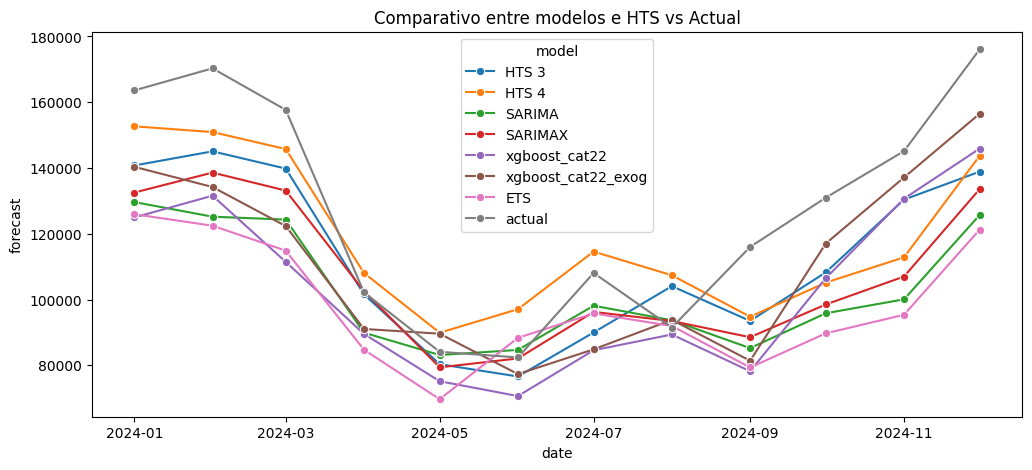

In [86]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=comparison_df, x="date", y="forecast", hue="model", ax=ax, marker="o")
ax.set_title("Comparativo entre modelos e HTS vs Actual")
plt.show()